# Call Spectre.exe and Run loops

In [7]:
'''
Due to Subprocess ('proc.stdin.write') alway display something in the screen and 'communicate' function which does not 
display something but terminate the process every run
we turn to python module Winpexpect has functions giving no display but it is slower.

But if input all the 'start spectra', 'set parameters' and 'fit' commonds in a 'communicate', it work well.

For solving the hang problem of 'readline()': search this webpage Non blocking reading from a subprocess output stream in Python

Our demand: 
1, capture 'error' displayed or just copy 'RESULT.DAT'
2. in the loop, no display, no terminate
3. fast
'''

import numpy as np
import matplotlib.pyplot as plt
import os, sys
import re
import fnmatch

import seaborn as sns # it will set to SNS style
sns.reset_orig() # set back to the Matplotlib style
sns.set() # set to sns style
# set the font
plt.rcParams["font.family"] = 'arial'
%matplotlib notebook

import string

import subprocess

In [2]:
## Ｃａｌｌ　Ｓｐｅｃｔｒｅ　ｖｉａ　ＣＭＤ．ｅｘｅ　：　works
proc = subprocess.Popen('cmd.exe', stdin = subprocess.PIPE, stdout = subprocess.PIPE,
                       encoding='utf8')

proc.stdin.write('D: \n')
proc.stdin.write('cd D:\9_Program files\crystal_field \n')
proc.stdin.write('spectre.exe \n')
# here can insert cmd setting Bkq, ion type...
# netron
# neutron = ['\n']
# output = proc.communicate('\n')[0]
# mh calculation
mh = ['7', '2', '0,0,5','y','art2.txt'] # max feild [0,0,5]T, write to file name
output = proc.communicate('\n' + '\n'.join(mh) + '\n')[0]

# 'communicate' terminates the exe
print(output)
#proc.terminate()

## the old code also work which is input one by one
#proc.stdin.write('\n 7 \n 2\n 0,0,5 \n y \n art1.txt \n') # not working
# proc.stdin.write(' \n')
# proc.stdin.write('7 \n')
# proc.stdin.write('2 \n')
# proc.stdin.write('0,0,5 \n')
# proc.stdin.write('y \n')
# proc.stdin.write('art1.txt \n')
# output = proc.stdout.readline()
# print len(output)
# for idx in range(len(output)-4): # if range is larger than the output, it will wait for output
#     line = proc.stdout.readline()
#     if line != '':
#         print line.rstrip()
#         #data=myfile.read().replace
#     else:
#         break
#stdout, stderr = proc.communicate(' \n') # 'communicate' terminates the exe


Microsoft Windows [Version 10.0.17134.472]
(c) 2018 Microsoft Corporation. All rights reserved.

C:\Users\kew\0_MyIpython\Crystal_field>D: 

D:\>cd D:\9_Program files\crystal_field 

D:\9_Program files\crystal_field>spectre.exe 





                  CEF Parameters (meV):

    1  B(2,0) =  0.102E+03  2  B(4,0) =  0.400E+03  3  B(6,0) =  0.146E+03
    4  B(2,1)c =  0.000E+00  16  B(2,1)s =  0.000E+00
    5  B(2,2)c =  0.000E+00  17  B(2,2)s =  0.000E+00
    6  B(4,1)c =  0.000E+00  18  B(4,1)s =  0.000E+00
    7  B(4,2)c =  0.000E+00  19  B(4,2)s =  0.000E+00
    8  B(4,3)c =  0.222E+02  20  B(4,3)s =  0.000E+00
    9  B(4,4)c =  0.000E+00  21  B(4,4)s =  0.000E+00
   10  B(6,1)c =  0.000E+00  22  B(6,1)s =  0.000E+00
   11  B(6,2)c =  0.000E+00  23  B(6,2)s =  0.000E+00
   12  B(6,3)c = -0.108E+03  24  B(6,3)s =  0.000E+00
   13  B(6,4)c =  0.000E+00  25  B(6,4)s =  0.000E+00
   14  B(6,5)c =  0.000E+00  26  B(6,5)s =  0.000E+00
   15  B(6,6)c =  0.877E+02  27  B(6,6)s =  0.000E+00

 

In [8]:
#  Ｄｅｆｉｎｉｎｇ　ａ　ｃｌａｓｓ　ｔｏ　ｒｕｎ　ｔｈｅ　ｅｘｅ　ｆｉｌｅ ａｎｄ　ｃａｌｃｕｌａｔｅｓ (not used)

class cef_cal():
    ''' Set which ion manually in Spectre first!!!!
    console(set_pars): call Spectre via cmd, the set parameters set_pars: Bqk, B field; 
    cal_nd(set_pars,ndfpath): cal crystal field neutron scatering, and save to file;
    fit_nd(set_pars,cmds,ndfpath):input data, fit and save display to file by Python(Spectre also yields a file)
    cal_mh(set_pars,cmds):calcualted mh at a temperature, field direction and seve to file by Spectre
    '''
         
    def console(self,**kwarg):       
        proc = subprocess.Popen('cmd.exe', 
                                stdin = subprocess.PIPE, stdout = subprocess.PIPE,encoding='utf8')
        proc.stdin.write('D: \n')
        #proc.stdin.write('cd D:\9_Program files\crystal_field\Spectre \n')
        proc.stdin.write('cd D:\9_Program files\crystal_field \n')
        proc.stdin.write('spectre.exe \n')
        
        for par in set_pars:
            print('par', par)
            proc.stdin.write(par+'\n')
        proc.stdin.write('\n')
            
        setpars = proc.stdout.readline()
        print(len(setpars), setpars)
        for idx in range(len(setpars)-4): # if range is larger than the output, it will wait for output
            line = proc.stdout.readline()
            if line != '':
                print(line.rstrip())
            else:
                break 
        return(proc)          

    def cal_nd(self,set_pars,ndfpath):# set pars, cal, then write to a file by Python
        nd_output = self.console(set_pars).communicate('\n'+'1'+'\n')[0]
        #print nd_output
        with open(ndfpath,'a+') as f: # append or reading, if not exist then creat
            f.writelines(nd_output)
            f.close()
        return()
    def fit_nd(self,set_pars,cmds,ndfpath):
        nd_output = self.console(set_pars).communicate('\n'+'4'+'\n'+'\n'+'\n'.join(cmds)\
                                                       +'\n'+'\n'+'\n'+'y'+'\n')[0]
        # meaning of the cmds: \n enter main menu, 4\n select fit, \n not going to fit existing data, 
        # \n.join(cmds) input data, \n,\n input v return to E,C,R,V.. menu, \n fit,y\n save
        with open(ndfpath,'a+') as f: # append or read, if not exist then creat
            f.writelines(nd_output)
            f.close()
        return()
        
        
    def cal_mh(self,set_pars,cmds):# set pars and par for cal, then write to a file by Spectre
        mh_output = self.console(set_pars).communicate('\n'+'7'+'\n'+cmds[0]+'\n'+cmds[1]+'\n'\
                                                       +'y'+'\n'+cmds[2]+'\n')[0]
        # \n enter main menu,7\n selcte cal MH, 2\n 2K, 005\n field direction,y\n save, file,txt filename
        #print mh_output
        return()

## Define funs for fitting CEF and calculating MH, MT, Cp... 

In [9]:
# Ｄｅｆｉｎｅ　ｆｕｎｓ　ｎｏｔ　ｃｌａｓｓ　ｆｏｒ　ｃａｌ：　
# ｗｈｅｎ　ｕｓｉｎｇ，　ｆｉｒｓｔ　ｒｕｎ　ｃｏｎｓｏｌｅ　ｔｈｅｎ　ｒｕｎ　ｏｔｈｅｒｓ　ｗｉｔｈ　ｔａｋｉｎｇ　ｔｈｅ　ｐｒｏｃｅｓｓ　ａｓ　ｉｎｐｕｔ
# Note: 'stdin.write' seem not waiting for the finish of the run of evrey cmd

''' Set which ion manually in Spectre first!!!!
console(set_pars): call Spectre via cmd, the set parameters set_pars: Bqk, B field; 
cal_nd(set_pars,ndfpath): cal crystal field neutron scatering, and save to file;
fit_nd(set_pars,cmds,ndfpath):input data, fit and save display to file by Python(Spectre also yields a file)
cal_mh(set_pars,cmds):calcualted mh at a temperature, field direction and seve to file by Spectre
''' 
import subprocess
import os
def console(**kwargs):
    set_pars = []
    if kwargs:
        for kw in kwargs:
            if kw=='set_pars': set_pars=kwargs[kw]
                
    #start Spectre
    proc = subprocess.Popen(['cmd.exe','-u','stdbuf'], bufsize=0, 
                            stdin = subprocess.PIPE, stdout = subprocess.PIPE, encoding='utf8')
    proc.stdin.write('D: \n')
    proc.stdin.write('cd D:\9_Program files\crystal_field \n')
    proc.stdin.write('spectre.exe \n')
    #instea of above for calling Spectre, blow lines also works
#   proc.stdin.write('D: \n'+'cd D:\9_Program files\crystal_field \n'+'spectre.exe \n')
   
    if set_pars:
        for par in set_pars:
            #print 'par', par
            proc.stdin.write(par+'\n')
        proc.stdin.write('\n')          
#     if set_pars: # try 'write', but not work here in Spectre; 'write' not wait for running?
#         proc.stdin.write('\n'.join(set_pars))
#         proc.stdin.write('\n')
        
    #output = proc.stdout.readline()    
    #print 'length of output', len(output),'\n', output, '\n', 'Output ends'   
#     for idx in range(len(output)-4): # if range is larger than the output, it will wait for output
#         line = proc.stdout.readline()
#         if line != '':
#             print line.rstrip('\n')
#         else:
#             break 
    return(proc)

def start_setPar_fit(fitcmds, **kwargs):
    set_pars = []
    save_path = []
    if kwargs:
        for kw in kwargs:
            if kw=='set_pars': set_pars=kwargs[kw]
            if kw=='save_path': save_path=kwargs[kw]    
    #start Spectr，set CEF parameters and do fitting
    proc = subprocess.Popen('cmd.exe', stdin = subprocess.PIPE, stdout = subprocess.PIPE)
    if set_pars:
        output = proc.communicate('D: \n'+'cd D:\9_Program files\crystal_field \n'+'spectre.exe \n'+ \
                                  '\n'.join(set_pars)+'\n'+'\n'+ \
                                  '\n'+'4'+'\n'+'\n'+'\n'.join(fitcmds)+'\n'+'\n'+'\n'+'y'+'\n')[0]
    else:
        output = proc.communicate('D: \n'+'cd D:\9_Program files\crystal_field \n'+'spectre.exe \n'+ \
                                  '\n'+'4'+'\n'+'\n'+'\n'.join(cmds)+'\n'+'\n'+'\n'+'y'+'\n')[0]
    if save_path:    
        with open(save_path,'w+') as f:
            f.writelines(output)
            f.close()   
    return


def fit_cef(proc,cmds,fpath,fname):
    output = proc.communicate('\n'+'4'+'\n'+'\n'+'\n'.join(cmds)+'\n'+'\n'+'\n'+'y'+'\n')[0]
    #meaning of the cmds: \n enter main menu, 4\n select fit, \n not going to fit existing data, 
    #\n.join(cmds) input data, \n,\n input v return to E,C,R,V.. menu, \n fit,y \n save
    with open(os.path.join(fpath,fname),'w+') as f: # append or read, if not exist then creat
        f.writelines(output)
        f.close()     
    return

def fit_cef1(proc,cmds,fpath,fname):
# because 'communicate' kills the proc when finishing, so try 'write' but cannot get output (to see 'error' or not)
    proc.stdin.write('\n'+'4'+'\n'+'\n'+'\n'.join(cmds)+'\n'+'\n'+'\n'+'y'+'\n')
    proc.stdin.flush() 
    #proc.wait() #hangs and spectra above is also waiting
    #output = proc.stdout.readlines() #hangs
#     for out in proc.stdout: # this can disply part but also hangs
#         print outr.strip('\n').split()
#     for line in iter(proc.stdout.readline, b''):# this can disply all but also hangs, can not run the next fit
#         print line.strip('\n').split()
    #proc.stdout.close()
#     with open(os.path.join(fpath,fname),'w+') as f: 
#         f.write(output)
#         f.close() 
#     print repr(output)
#     #print 'length of output', len(output),output.rstrip()
#     with open(os.path.join(fpath,fname),'w+') as f: 
#         for line in output: 
#             #print line.rstrip()
#             f.write(line.rstrip())
#     f.close()        
    return

def fit_cef2(proc,cmds,fpath,fname):
# because 'communicate' kills the proc when finishing, 
# so try 'write' and use communicate to get the output but it terminates the proc (no benifit) 
    proc.stdin.write('\n'+'4'+'\n'+'\n'+'\n'.join(cmds)+'\n'+'\n'+'\n'+'y'+'\n')
    output = proc.communicate()[0]
    #print output
    # loop all line to search 'error', we can also regular expression matching (see Notebook winpexpect)
    if any("ERROR!" in line.rstrip('\n').split() for line in output.split('\n\n')):#'output' is a string with 
        # single letter column, so split it based on '\n\n' into a list
        print('error','bad fit')
    else:
        print('Success')   
    return     

def cal_mh(proc,cmds):# cmds: ['2', '0 0 5', 'fname.txt'] (temp, field,filename)
    mh_output = proc.communicate('\n'+'7'+'\n'+cmds[0]+'\n'+cmds[1]+'\n'+'y'+'\n'+cmds[2]+'\n')[0]
    #meaning:\n enter main menu,7\n selcte cal MH, 2\n 2K, 005\n field direction,y\n save, file,txt filename
    #print mh_output
    return

def cal_mh1(proc,temp,field,fpath):
    proc.stdin.write('\n')
    proc.stdin.write('7 \n')
    proc.stdin.write(str(temp))
    proc.stdin.write('\n')
    proc.stdin.write(field)
    proc.stdin.write('\n')
    proc.stdin.write('y \n')
    proc.stdin.write(fpath)
    proc.stdin.write('\n')
    proc.communicate()
    proc.terminate()
    #meaning: \n enter main menu,7\n selcte cal MH, 2\n 2K, 005\n field direction,y\n save, file,txt filename
    #print mh_output
    return

def cal_cp(proc,T_range_npts,fname):# The last two input must be strings
    proc.communicate('\n'+ '5 \n' + T_range_npts+'\n' +'y \n' +fname+'\n')
    return

def cal_xt(proc,maxT,fname):# The last two input must be strings
    proc.communicate('\n'+ '6 \n' + maxT+'\n' +'y \n' +fname+'\n')
    return


# Fitting the Sm2Hf2O7 neutron data

In [50]:
# fitting

# set initio pars
sm_pars =  ['1,42',  '2,320', '3,103', '8,85', '12,-70', '15,96']# Scaled Nd2Zr2O7 pars
#sm_pars =  ['1,90',  '2,320', '3,103', '8,85', '12,-70', '15,96']# modified Scaled Nd pars
sm_pars1 = ['1 28.5','2 370', '3 86',  '8 97', '12 -78', '15 123']# JPCM paper Sm2Ti2O7
#sm_pars1 = ['1 70',  '2 370', '3 86',  '8 97', '12 -78', '15 123']# Modified JPCM paper Sm2Ti2O7
sm_pars2 = ['1,47',  '2,294', '3,83',  '8,109','12,-62', '15,110']# Scaled Pr2Sn2O7 pars
sm_pars3 = ['1,28',  '2,289', '3,95',  '8,131','12,-64', '15,102']# Scaled Pr2Hf2O7 pars

last = ['1,98', '2,412', '3,150',  '8,75','12,-100', '15,103']

idx = ['1,','2,','3,','8,','12,','15,']

#np.core.defchararray.add
#np.char.array(idx) + np.char.array
#[x1 + x2 for x1,x2 in zip(idx, map(str,[100.5, 403.3, 145.1, 19.19, -111.5, 82.23]))]

best_fit = [x1 + x2 for x1,x2 in zip(idx, best.astype(str))]# np.char.array(idx) + np.char.array(list())

proc = console(set_pars = best_fit)
proc.communicate()


('Microsoft Windows [Version 10.0.17134.472]\n(c) 2018 Microsoft Corporation. All rights reserved.\n\nC:\\Users\\kew\\0_MyIpython\\Crystal_field>D: \n\nD:\\>cd D:\\9_Program files\\crystal_field \n\nD:\\9_Program files\\crystal_field>spectre.exe \n\n\n\n\n\n                  CEF Parameters (meV):\n\n    1  B(2,0) =  0.991E+02  2  B(4,0) =  0.405E+03  3  B(6,0) =  0.145E+03\n    4  B(2,1)c =  0.000E+00  16  B(2,1)s =  0.000E+00\n    5  B(2,2)c =  0.000E+00  17  B(2,2)s =  0.000E+00\n    6  B(4,1)c =  0.000E+00  18  B(4,1)s =  0.000E+00\n    7  B(4,2)c =  0.000E+00  19  B(4,2)s =  0.000E+00\n    8  B(4,3)c = -0.173E+02  20  B(4,3)s =  0.000E+00\n    9  B(4,4)c =  0.000E+00  21  B(4,4)s =  0.000E+00\n   10  B(6,1)c =  0.000E+00  22  B(6,1)s =  0.000E+00\n   11  B(6,2)c =  0.000E+00  23  B(6,2)s =  0.000E+00\n   12  B(6,3)c =  0.114E+03  24  B(6,3)s =  0.000E+00\n   13  B(6,4)c =  0.000E+00  25  B(6,4)s =  0.000E+00\n   14  B(6,5)c =  0.000E+00  26  B(6,5)s =  0.000E+00\n   15  B(6,6)c =  

In [17]:
proc.communicate()
#proc.terminate()

('Microsoft Windows [Version 10.0.17134.472]\n(c) 2018 Microsoft Corporation. All rights reserved.\n\nC:\\Users\\kew\\0_MyIpython\\Crystal_field>D: \n\nD:\\>cd D:\\9_Program files\\crystal_field \n\nD:\\9_Program files\\crystal_field>spectre.exe \n\n\n\n\n\n                  CEF Parameters (meV):\n\n    1  B(2,0) =  0.492E+02  2  B(4,0) =  0.409E+03  3  B(6,0) =  0.148E+03\n    4  B(2,1)c =  0.000E+00  16  B(2,1)s =  0.000E+00\n    5  B(2,2)c =  0.000E+00  17  B(2,2)s =  0.000E+00\n    6  B(4,1)c =  0.000E+00  18  B(4,1)s =  0.000E+00\n    7  B(4,2)c =  0.000E+00  19  B(4,2)s =  0.000E+00\n    8  B(4,3)c =  0.122E+03  20  B(4,3)s =  0.000E+00\n    9  B(4,4)c =  0.000E+00  21  B(4,4)s =  0.000E+00\n   10  B(6,1)c =  0.000E+00  22  B(6,1)s =  0.000E+00\n   11  B(6,2)c =  0.000E+00  23  B(6,2)s =  0.000E+00\n   12  B(6,3)c = -0.980E+02  24  B(6,3)s =  0.000E+00\n   13  B(6,4)c =  0.000E+00  25  B(6,4)s =  0.000E+00\n   14  B(6,5)c =  0.000E+00  26  B(6,5)s =  0.000E+00\n   15  B(6,6)c =  

In [55]:
Is = np.array([0.0086,0.0442,0.0087,0.0444,0.1838,0.0720,0.5922])+\
     np.array([0.0409,0.0879,0.0242,0.4404,0.1896,0.6466,1.0556])
Is/Is[-1]

array([0.03004005, 0.0801675 , 0.01996602, 0.29421046, 0.22660517,
       0.43609661, 1.        ])

In [53]:
# fitting
# Neutron data for inter-multiplet transitions
fitcmd0=['e','1 2 0 0.1', '1 7 128 2','1 8 128 2', '1 9 156 4','1 10 156 4',
        '1 11 167 4','1 12 167 4', '1 13 183 3','1 14 183 3 \n',
       'c','1 7','1 8 \n', 'c','1 9','1 10 \n', 'c','1 11', '1 12 \n',
       'c','1 13', '1 14 \n',
        'r', '6 1 7','6 1 13','0.31 0.1',
             '6 1 9','6 1 13','0.26 0.1',
             '6 1 11','6 1 13','0.34 0.15 \n',
        'v','1','2','3','8','12','15']
# Test exchanged energy of the two peak close to each other
fitcmd1=['e','1 2 0 0.1', '1 7 130 3','1 8 130 3', '1 9 168 5','1 10 168 5',
        '1 11 157 5','1 12 157 5', '1 13 183 5','1 14 183 5 \n',
       'c','1 7','1 8 \n', 'c','1 9','1 10 \n', 'c','1 11', '1 12 \n',
       'c','1 13', '1 14 \n',
        'r', '6 1 7','6 1 13','0.37 0.05',
             '6 1 9','6 1 13','0.38 0.08',
             '6 1 11','6 1 13','0.26 0.08 \n',
        'v','1','2','3','8','12','15']

fitcmd1=['e','1 2 0 0.1',
        '1 3 24 1', '1 4 24 1', '1 5 39 1', '1 6 39 1',# maunal data 
        '1 7 128 4','1 8 128 4', '1 9 156 5','1 10 156 5',
        '1 11 167 5','1 12 167 5', '1 13 183 5','1 14 183 5 \n',
        #'c','1 3','1 4 \n', 'c','1 5','1 6 \n',
        #'c','1 7','1 8 \n', 'c','1 9','1 10 \n', 'c','1 11', '1 12 \n','c','1 13', '1 14 \n',      
        #'r', #'6 1 3','6 1 13','0.01 0.01', # removed the intensity
             #'6 1 5','6 1 13','0.01 0.01',
        #     '6 1 7','6 1 13','0.30 0.1',
        #     '6 1 9','6 1 13','0.27 0.1',
        #     '6 1 11','6 1 13','0.31 0.15 \n',
        'v','1','2','3','8','12','15']

fpath = 'D:\9_Program files\crystal_field'
fname = 'sho_CEF_fit.txt' # file to store all the fitting output
proc = console()
#proc = console(set_pars = last)
fit_cef(proc,cmds,fpath,fname)
#proc.communicate()     

# Test the function: start Spectre, set parameter, fit and export the output to file
#start_setPar_fit(fitcmd, set_pars=last,save_path=r'D:\9_Program files\crystal_field\szo_CEF_fit.txt')


In [57]:
# calcualted x-t and Cp
# first delet the files
try:
    os.remove(r'D:\9_Program files\crystal_field\sho_cp.txt')
    os.remove(r'D:\9_Program files\crystal_field\sho_xt.txt')
    os.remove(r'D:\9_Program files\crystal_field\sho_mh.txt')
except:
    pass
proc = console()
cal_cp(proc,'2 300 100','sho_cp.txt')
proc = console()
cal_xt(proc,'350','sho_xt.txt')
proc = console()
cal_mh(proc,['2','0 0 14','sho_mh.txt'])

In [48]:
# read and plot the Cp and XT data
#convertfunc = lambda x: float(str(x).translate(str.maketrans('D','e'))) # make a translation table (rules) for translating a string (D to E in the numbers)  
convertfunc = lambda x: float(x.decode(encoding='utf-8', errors='strict').replace('D','E'))# byte-like object->str->convert

# def load_xt(fname):# a structureed array
#     temp = np.genfromtxt(fname, usecols=(0,1,2,3), 
#                          dtype=[('T','float'),('x_para','float'),('x_perp','float'),('x_pow','float')],
#                          names=['T','x_para','x_perp','x_pow'],
#                          converters = {'x_para': convertfunc, 'x_perp': convertfunc, 'x_pow': convertfunc}) 
#     return temp

def load_xt(fname):    
    temp = np.genfromtxt(fname, usecols=(0,1,2,3), 
                         converters = {1: convertfunc, 2: convertfunc, 3: convertfunc}) 
    return temp

# load data
fnames = [r'D:\9_Program files\crystal_field\sho_cp.txt',
          r'D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\szo_cp_diditalized.txt',
          r'D:\9_Program files\crystal_field\sho_xt.txt',
          r'D:\3_Physical Properties\Nd2Zr2O7\Crystal\szo_pow_xt_080114.txt']

cp = np.genfromtxt(fnames[0]) # calculated
cp1 = np.genfromtxt(fnames[1]) # data
xt = load_xt(fnames[2]) # calulated
xt1 = np.genfromtxt(fnames[3]) # data

<IPython.core.display.Javascript object>


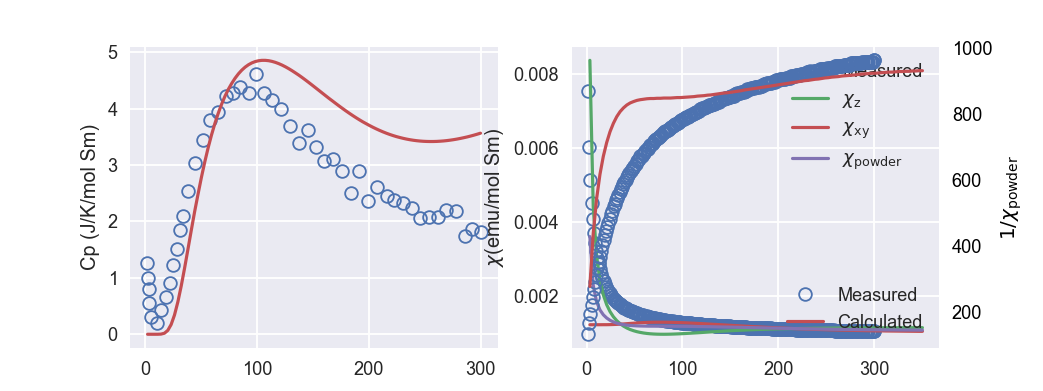

No handles with labels found to put in legend.


In [49]:
# plot
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(8,3))

# plot Cp
axs[0].plot(cp1[:,0],cp1[:,1],'bo',mec='b',mew='1',mfc='none')
axs[0].plot(cp[:,0],cp[:,1],'r')
axs[0].set_ylabel(r'Cp (J/K/mol Sm)')

# plot x-T
skipPts = 15
axs[1].plot(xt1[::skipPts,0],xt1[::skipPts,1]/2,'o',mec='b',mew='1',mfc='none',label=r'Measured')
axs[1].plot(xt[:,0],xt[:,1],label=r'$\chi_{\rm z}$')
axs[1].plot(xt[:,0],xt[:,2],label=r'$\chi_{\rm xy}$')

axs[1].plot(xt[:,0],xt[:,3],label=r'$\chi_{\rm powder}$')
axs[1].set_ylabel(r'$\chi$(emu/mol Sm)')

# plot 1/x-T
axs11 = axs[1].twinx()
axs11.grid(b=False)
axs11.plot(xt1[::skipPts,0],1./xt1[::skipPts,1]*2,'o',mec='b',mew='1',mfc='none', label='Measured')
axs11.plot(xt[:,0],1./xt[:,3],color='r', label='Calculated')
# Make the y-axis label and tick labels match the line color.
for tl in axs11.get_yticklabels():
    tl.set_color('black')
axs11.set_ylabel(r'$1/\chi_{\rm powder}$',color='black')

axs[0].legend()
axs[1].legend(loc='best')
axs11.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


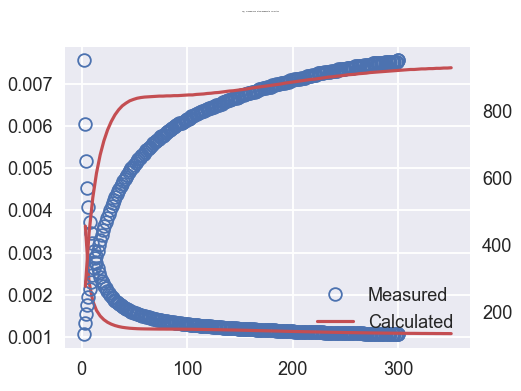

interactive(children=(FloatSlider(value=0.0, description='x1', max=0.0005, step=1e-05), Output()), _dom_classe…

<function __main__.pltDiaMag(x1=0.0)>

In [22]:
# Try subtracting the diamagnetic part
sns.set(color_codes=True)
skipPts = 15
def pltDiaMag(x1=0.0):
    global fig, ax, ax1
    ax.cla()  
    # plot x-T
    ax.plot(xt1[::skipPts,0],xt1[::skipPts,1]/2+x1,'o',mec='b',mew='1',mfc='none',label=r'Measured')
    ax.plot(xt[:,0],xt[:,3],color='r', label='Calculated')
    ax.set_ylabel(r'$\chi$(emu/mol Sm)')
    # plot 1/x-T
    ax1.cla()
    ax1.grid(b=False)
    ax1.plot(xt1[::skipPts,0],1./(xt1[::skipPts,1]+x1)*2,'o',mec='b',mew='1',mfc='none', label='Measured')
    ax1.plot(xt[:,0],1./xt[:,3],color='r', label='Calculated')
    ax1.set_ylabel(r'$1/\chi$(emu/mol Sm)')
    ax1.legend(loc='best')
    
    plt.suptitle(r'$\chi(T)$ of Sm$_2$Zr$_2$O$_7$ with diamganetic correction',fontsize=1)
    return #fig

fig, ax = plt.subplots(figsize=(4,3))
ax1 = ax.twinx()

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

interact(pltDiaMag, x1=widgets.FloatSlider(min=0,max=0.0005,step=0.00001,value=0.000))

In [51]:
# SmHfO
cmds=['e','1 2 0 0.1', '1 7 128 2','1 8 128 2', '1 9 156 4','1 10 156 4',
        '1 11 167 4','1 12 167 4', '1 13 183 3','1 14 183 3 \n',
       'c','1 7','1 8 \n', 'c','1 9','1 10 \n', 'c','1 11', '1 12 \n',
       'c','1 13', '1 14 \n',
        'r', '6 1 7','6 1 13','0.31 0.1',
             '6 1 9','6 1 13','0.26 0.1',
             '6 1 11','6 1 13','0.34 0.1 \n',
        'v','1','2','3','8','12','15']
# new fit with errorbars 1,9.0
cmds=['e','1 2 0 0.1', '1 7 128 2','1 8 128 2', '1 9 156 3','1 10 156 3',
        '1 11 167 4','1 12 167 4', '1 13 183 2','1 14 183 2 \n',
       'c','1 7','1 8 \n', 'c','1 9','1 10 \n', 'c','1 11', '1 12 \n',
       'c','1 13', '1 14 \n',
        'r', '6 1 7','6 1 13','0.30 0.1',
             '6 1 9','6 1 13','0.27 0.1',
             '6 1 11','6 1 13','0.31 0.15 \n',
        'v','1','2','3','8','12','15']
# SmZrO
cmds1 = ['e','1 2 0 0.1', '1 7 130 3','1 8 130 3', '1 9 157 5','1 10 157 5',
        '1 11 168 5','1 12 168 5', '1 13 183 5','1 14 183 5 \n',
       'c','1 7','1 8 \n', 'c','1 9','1 10 \n', 'c','1 11', '1 12 \n',
       'c','1 13', '1 14 \n',
        'r', '6 1 7','6 1 13','0.37 0.05',
             '6 1 9','6 1 13','0.26 0.08',
             '6 1 11','6 1 13','0.38 0.08 \n',
        'v','1','2','3','8','12','15']

In [63]:
# Ｔｒｙ　Ｒａｎｄｏｍ
storage = []
idxs = ['1,','2,','3,','8,','12,','15,']
iters=0

while iters<1:
    # start spectre
    proc = console()
    # set initio parameters
    randoms = (np.random.rand(6)-0.5)*100 # +/-50
    cefp = list(map(str, np.array([42,320,103,85,-70,96])+randoms))

    for idx, par in zip(idxs,cefp):
        proc.stdin.write(idx+par+'\n')
        print(idx, par)
    proc.stdin.write('\n') 
    # fitting
    proc.stdin.write('\n'+'4'+'\n'+'\n'+'\n'.join(cmds)+'\n'+'\n'+'\n'+'n'+'\n')# do not write to file
    output = proc.communicate()[0] #To get output and stop hang of python (wait for closing proc): 0 for out, 1 for err
    #sys.stdout.flush() # error: operate on closed process, becuase communicate terminates the proc
    
    #print(output) # good formated view
    
    # store key factors
    if "CHI" in output:
    #if any("ERROR!" in line.rstrip('\n').split() for line in output.split('\n\n')): # sometime succeed with error!!!
        print('Success')
        cefp.extend(['Success','\n'])
        storage.append(cefp)
    else:
        print('error')
        cefp.extend(['error','\n'])
        storage.append(cefp)
        
    iters = iters+1 
print(storage)    

1 51.420463347428544
2 361.10268084685265
3 114.71258480046153
8 39.617807047871146
12 -117.50230353341928
15 145.59016568739884
error
[['51.420463347428544', '361.10268084685265', '114.71258480046153', '39.617807047871146', '-117.50230353341928', '145.59016568739884', 'error', '\n']]


In [72]:
#print(output)
if "CHI" in output:
    print('Good')

for line in output.split('\n\n'):
    if 'CHI' in line.rstrip('\n').split():
        print(line)

Good
          CHI SQUARED =     0.1749


In [28]:
# Ｌｏｏｐｓ　ｗｉｔｈ　Ｒａｎｄｏｍ ｐａｒａｍｅｔｅｒ　ｗｉｔｈｉｎ　ａ　ｃｅｒａｔａｉｎ　ｒａｎｇｅ
fpath = r'D:\9_Program files\crystal_field\sho_output2'
f1 = open(os.path.join(fpath,'Bs_starting.txt'), 'a+', buffering=1) # file to store the starting B parameters (cannot have unbufering IO)
#f1.write(' '.join(['B20','B40','B60','B43','B63','B66','Result','\n'])) # write headers
max_iters = 60

import shutil, time
start = time.time()

#start Spectre
idxs = ['1,','2,','3,','8,','12,','15,']

iters=0
while iters<max_iters:
    # set initio parameters (plus randoms)
    #print(iters)
    # For ranges:90-110,400-420,140-160,70-80,-90--110,90-110
    randoms = np.concatenate([(np.random.rand(1)-0.5)*2*50, 
                              (np.random.rand(1)-0.5)*2*200,
                              (np.random.rand(1)-0.5)*2*70,
                              (np.random.rand(1)-0.5)*2*30,
                              (np.random.rand(2)-0.5)*2*50])
    cefp = list( map( str, np.around(np.array([90,410,150,70,-100,100])+randoms, decimals=0) ) )

    # Start spectre
    proc = console()
    # Set initio parameters
    for idx, par in zip(idxs,cefp):
        proc.stdin.write(idx+par+'\n')
        #print(idx, par)
    proc.stdin.write('\n') 
    
    # fitting
    proc.stdin.write('\n'+'4'+'\n'+'\n'+'\n'.join(fitcmd1)+'\n'+'\n'+'\n'+'n'+'\n')# do not write to file
    output = proc.communicate()[0] #To get output and stop hang of python (wait for closing proc): 0 for out, 1 for err
    #sys.stdout.flush() # error: operate on closed process, becuase communicate terminates the proc    
    #print(output) # good formated view
    
    # store key factors
    if "CHI" in output:
    #if any("ERROR!" in line.rstrip('\n').split() for line in output.split('\n\n')): # sometime succeed with error!!!
        print('Success')
        cefp.extend(['Success','\n'])
    else:
        print('error')
        cefp.extend(['error','\n'])
        
    # write initio par to file
    f1.write(' '.join(cefp))
    f1.flush()

    shutil.copy(r'D:\9_Program files\crystal_field\RESULT.DAT', os.path.join(fpath,'RESULT%0.3d.DAT'%iters))# '005.dat' like name to sort file order
    
    iters = iters+1 
    
f1.close()

end = time.time()
print(end - start)

error
error
error
Success
error
Success
error
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
error
Success
error
Success
error
error
error
error
Success
Success
Success
Success
error
Success
Success
Success
Success
Success
Success
error
Success
error
Success
Success
Success
Success
Success
Success
error
error
Success
Success
Success
Success
Success
Success
error
error
Success
Success
Success
Success
2749.9313473701477


In [44]:
# Copy the fitted CEF pars and Chisq to a file and plot
# Search and match in a text file
#http://stackoverflow.com/questions/10477294/how-do-i-search-for-a-pattern-within-a-text-file-using-python-combining-regex

fname='RESULT*.DAT'
fpath = r'D:\9_Program files\crystal_field\sho_output1'
fnames=[] # store all the right file names in the folder
for file in os.listdir(fpath):
    if fnmatch.fnmatch(file, fname):      
        fnames.append(file)

# write them to a file
final = open(os.path.join(fpath,'Bs_chisq.txt'),"w+") # append writing
final.write(' '.join(['B20','B40','B60','B43','B63','B66','Chisq','\n'])) # write headers

for fname in fnames:   
    #print(fname)
    fname = os.path.join(fpath,fname)
    f = open(fname, 'r')
    ftext = f.read()
    f.close()
    m1 = re.findall("(B\([246],[036]\)[\ *c]?)\s+=\s+(-?\d+\.\d+E[-+]\d+)", ftext)
    m2 = re.findall("(CHI SQUARED)\s+=\s+(\d+\.\d+)", ftext)
    if m1 and m2:
        #print(m1, m2) 
        final.write(' '.join([m1[0][1],m1[1][1],m1[2][1],m1[3][1],m1[4][1],m1[5][1],m2[0][1],'\n']))
    else:
        final.write(' '.join(['Nan','Nan','Nan','Nan','Nan','Nan','Nan','\n']))# Write 'Nan' for bad fittings with not futll output
        
final.close()  

In [45]:
# load ｆｉｔｔｅｄ　CEF parameters　ａｎｄ　ｃｈｉ
dat = np.genfromtxt(os.path.join(fpath,'Bs_chisq.txt'), skip_header=1)
chi = dat[:,6] # used for plotting Bs_starting.txt
#dat[~np.isnan(dat[:,0]),:] 
print(dat.shape)

# the best fit CEF paras
best = dat[np.nanargmin(dat[:,6]),0:6]
print(best)
idx_sort = np.argsort(dat[:,6])
dat_sort = dat[idx_sort,:]
print(idx_sort)
print(dat_sort)

# there is one bad data point
best_idx = 2
best,best_chi = dat_sort[best_idx,:6], dat_sort[best_idx,6],
print(best,best_chi,fnames[idx_sort[best_idx]])

(160, 7)
[ -55.83   422.5      5.579   33.28  -154.6    -76.91 ]
[ 45 104  31  96 116 125  17  22  12 118  92  63 135  91 142  60  79 137
  76 156 153  14 130 145  18  50   8  24 106 126  85  53 150 102 128  99
  33  80  21 140 127  52  56  47 105  87  23 157 110 132   9  97  29   1
   6  58   0 141 152 101  54  73  16  57  19  40  30  13  49  68 159  43
  25  94 120 100  27 113 158  34  95  98 146  28 147  75  86  32  38 133
 134  15  71 131  64 129  20  26 124 123  62 136 139 138   2   3 155 154
   4  59 151  61   5 148   7 144 143  10  51  11 149 122 115 119  90  89
  88  44  84  83  82  81  46  78  77  48  74  69  72  42 121  41  67 117
  65  70 114 112 111 109  55 107  35  36 103  37  66  39  93 108]
[[-5.583e+01  4.225e+02  5.579e+00 ... -1.546e+02 -7.691e+01  2.940e-02]
 [ 1.005e+02  4.033e+02  1.451e+02 ... -1.115e+02  8.223e+01  1.857e-01]
 [ 9.907e+01  4.050e+02  1.445e+02 ...  1.144e+02  7.910e+01  1.894e-01]
 ...
 [       nan        nan        nan ...        nan        nan 

<IPython.core.display.Javascript object>


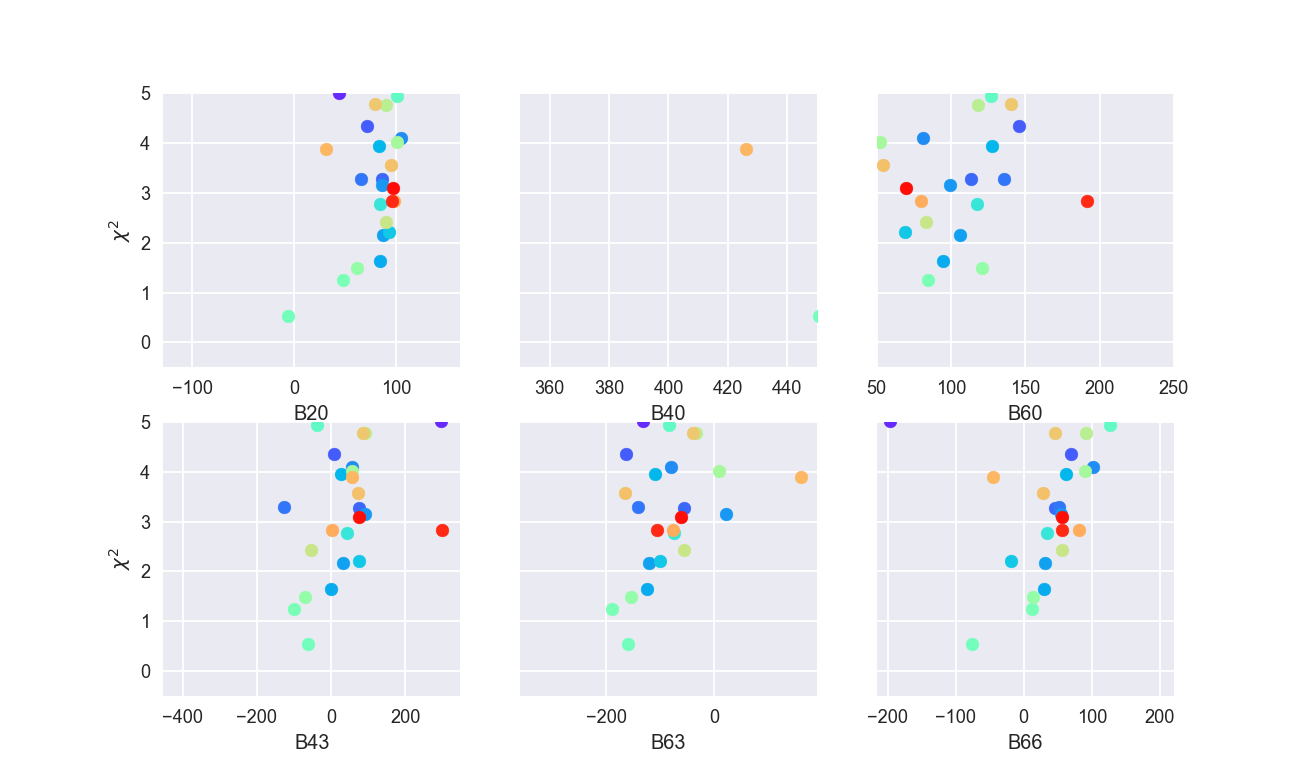

In [33]:
# Plot the CEF parameters vs chi
# Later can try to link those figure(mouse coursor), we can refer the expamle
# http://stackoverflow.com/questions/13306519/get-data-from-plot-with-matplotlib

label = ['B20','B40','B60','B43','B63','B66']

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(dat)))# plot pars of the same set with the same color
iis = list(map(str, np.arange(0,len(dat))))
           
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=True, figsize=(10,6))
for idx, ax in enumerate(axs.reshape(-1)):
    #print(idx)
    for x, y, c, ii in zip(dat[:,idx], chi, colors, iis):
    #for x, y, c in zip(dat[:,idx], chi, colors):
        ax.scatter(x, y, color=c)
        #ax.text(x, y, ii)
    ax.set_xlabel(label[idx])
    ax.autoscale_view(True,True,True)
    ax.tick_params(axis='both', which='major')
    ax.grid(True)
    if idx==0 or idx==3:
        ax.set_ylabel(r'$\chi^2$')        
    #ax.plot(dat[:,idx],dat[:,6],'o')

axs[0,0].set_ylim([-0.5,5])    
axs[0,1].set_xlim([350,450])
axs[0,2].set_xlim([50,250])   
#plt.suptitle('Fitted CEF parameters (meV) vs Chi')   
#fig.savefig(os.path.join(fpath,'szo_cef_random.pdf'), bbox_inches="tight",verbose=True)  
plt.show()

In [238]:
# plot the starting CEF parameters
dat0 = np.genfromtxt(os.path.join(fpath,'Bs_starting.txt'),usecols=[0,1,2,3,4,5], skip_header=0)
print(dat0.shape)

(160, 6)


<IPython.core.display.Javascript object>


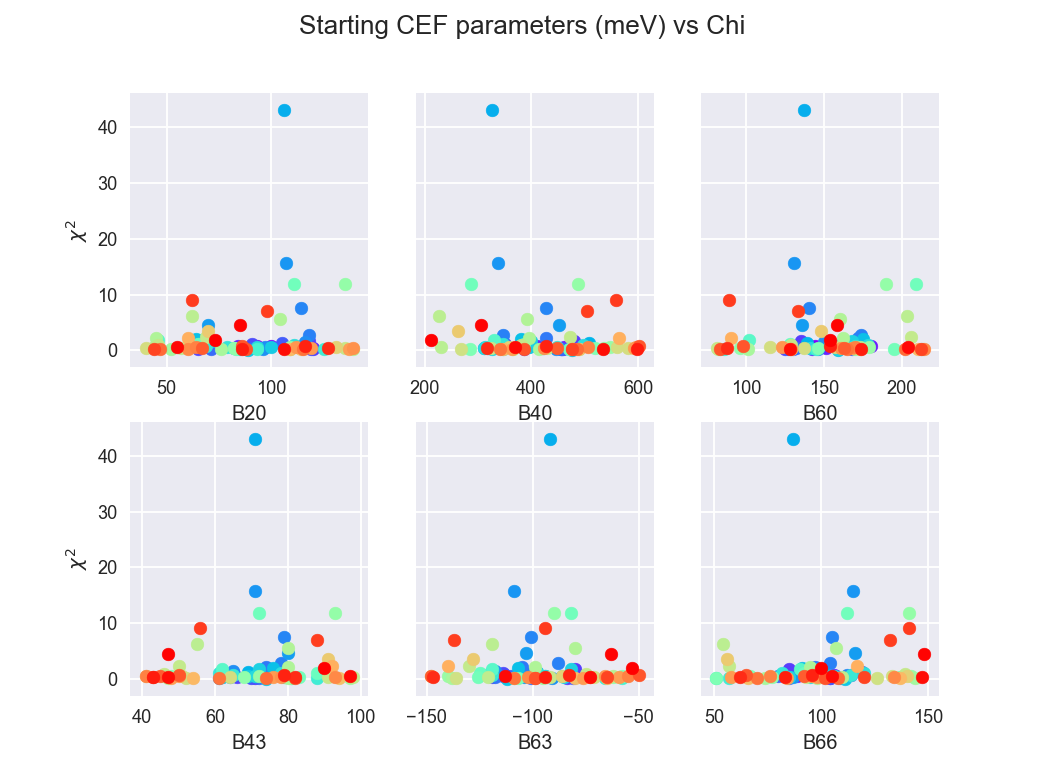

In [242]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=True, figsize=(8,6))
for idx, ax in enumerate(axs.reshape(-1)):
    for x, y, c in zip(dat0[:,idx],chi, colors):
        ax.scatter(x, y, color=c)
    ax.set_xlabel(label[idx])
    if idx==0 or idx==3:
        ax.set_ylabel(r'$\chi^2$')
    #ax.plot(dat[:,idx],dat[:,6],'o')
plt.suptitle('Starting CEF parameters (meV) vs Chi')   
plt.show()

In [244]:
import plotly.plotly as py
import plotly.graph_objs as go
py.sign_in('jianhui', 'ptwlq2r5kl')

# Create traces
trace0 = go.Scatter(x = chi,y = dat[:,0],mode = 'markers',name = 'B20')
trace1 = go.Scatter(x = chi,y = dat[:,1],mode = 'markers',name = 'B40')
trace2 = go.Scatter(x = chi,y = dat[:,2],mode = 'markers',name = 'B60')
trace3 = go.Scatter(x = chi,y = dat[:,3],mode = 'markers',name = 'B43')
trace4 = go.Scatter(x = chi,y = dat[:,4],mode = 'markers',name = 'B63')
trace5 = go.Scatter(x = chi,y = dat[:,5],mode = 'markers',name = 'B66')
# trace00 = go.Scatter(x = chi,y = dat0[:,0],mode = 'markers',name = 'sB20')
# trace01 = go.Scatter(x = chi,y = dat0[:,1],mode = 'markers',name = 'sB40')
# trace02 = go.Scatter(x = chi,y = dat0[:,2],mode = 'markers',name = 'sB60')
# trace03 = go.Scatter(x = chi,y = dat0[:,3],mode = 'markers',name = 'sB43')
# trace04 = go.Scatter(x = chi,y = dat0[:,4],mode = 'markers',name = 'sB63')
# trace05 = go.Scatter(x = chi,y = dat0[:,5],mode = 'markers',name = 'sB66')

# try to put chi on th chi axis for, grab data base on y axis, failed
# trace0 = go.Scatter(x = dat[:,0],y = chi,mode = 'markers',name = 'B20')
# trace1 = go.Scatter(x = dat[:,1],y = chi,mode = 'markers',name = 'B40')
# trace2 = go.Scatter(x = dat[:,2],y = chi,mode = 'markers',name = 'B60')
# trace3 = go.Scatter(x = dat[:,3],y = chi,mode = 'markers',name = 'B43')
# trace4 = go.Scatter(x = dat[:,4],y = chi,mode = 'markers',name = 'B63')
# trace5 = go.Scatter(x = dat[:,5],y = chi,mode = 'markers',name = 'B66')
# trace00 = go.Scatter(x = dat0[:,0],y = chi,mode = 'markers',name = 'sB20')
# trace01 = go.Scatter(x = dat0[:,1],y = chi,mode = 'markers',name = 'sB40')
# trace02 = go.Scatter(x = dat0[:,2],y = chi,mode = 'markers',name = 'sB60')
# trace03 = go.Scatter(x = dat0[:,3],y = chi,mode = 'markers',name = 'sB43')
# trace04 = go.Scatter(x = dat0[:,4],y = chi,mode = 'markers',name = 'sB63')
# trace05 = go.Scatter(x = dat0[:,5],y = chi,mode = 'markers',name = 'sB66')

layout = go.Layout(
    autosize=False,
    width=1000,
    height=800,
    margin=go.Margin(
        l=0,
        r=0,
        b=0,
        t=0,
        pad=0
    )
)

#data = [trace0, trace1, trace2, trace3, trace4, trace5,trace00, trace01, trace02, trace03, trace04, trace05]
data = [trace0, trace1, trace2, trace3, trace4, trace5]
fig = go.Figure(data=data, layout=layout)
#py.iplot(data, filename='scatter-mode')# only this also works
py.iplot(fig, filename='scatter-mode')

C:\ProgramData\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:396: DeprecationWarning:

plotly.graph_objs.Margin is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Margin




High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~jianhui/0 or inside your plot.ly account where it is named 'scatter-mode'
